Tuned XGBoost Model

Best number of trees: 131


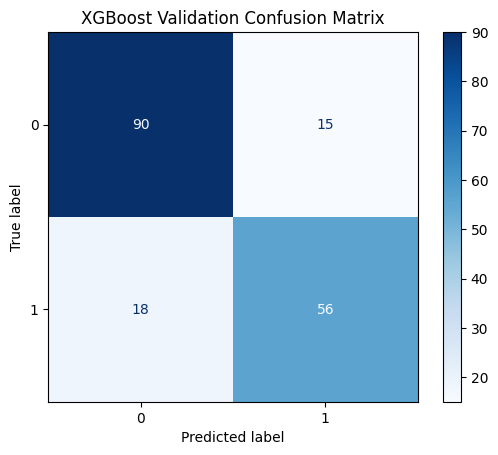

AUC: 0.8956241956241956
Ready for Kaggle: ../submissions/submission_xgb_tuned.csv


In [1]:
# ============================================================
# Tuned XGBoost using xgb.train (works on all versions)
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    precision_recall_curve
)
import json
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier

# ============================================================
# 1. Load data
# ============================================================

train = pd.read_csv("../data/processed_v2/train_features.csv")
test = pd.read_csv("../data/processed_v2/test_features.csv")

test_passenger_ids = test["PassengerId"]
y = train["Survived"]
X = train.drop(columns=["Survived", "PassengerId"])
X_test_final = test.drop(columns=["PassengerId"])

# ============================================================
# 2. Metadata
# ============================================================

with open("../data/processed_v2/processed_metadata.json", "r") as f:
    meta = json.load(f)

categorical_cols = list(meta.keys())
numeric_cols = [col for col in X.columns if col not in categorical_cols]

# ============================================================
# 3. Preprocessing
# ============================================================

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", StandardScaler(), numeric_cols),
    ]
)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit preprocessing
preprocess.fit(X_train)
X_train_t = preprocess.transform(X_train)
X_val_t = preprocess.transform(X_val)

# Convert to DMatrix
dtrain = xgb.DMatrix(X_train_t, label=y_train)
dval = xgb.DMatrix(X_val_t, label=y_val)

# ============================================================
# 4. XGBoost parameters
# ============================================================

params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "learning_rate": 0.05,
    "max_depth": 3,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "min_child_weight": 1,
    "gamma": 0.0,
    "eta": 0.05
}

# ============================================================
# 5. Train with early stopping
# ============================================================

evals = [(dtrain, "train"), (dval, "eval")]

xgb_model_temp = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=800,
    evals=evals,
    early_stopping_rounds=30,
    verbose_eval=False
)

best_n = xgb_model_temp.best_iteration + 1
print("Best number of trees:", best_n)

# ============================================================
# 6. Evaluate on validation
# ============================================================

y_proba = xgb_model_temp.predict(dval)
y_pred = (y_proba >= 0.5).astype(int)

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("XGBoost Validation Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(y_val, y_proba)
auc = roc_auc_score(y_val, y_proba)
print("AUC:", auc)

# ============================================================
# 7. Build final sklearn pipeline for full training
# ============================================================

xgb_final = XGBClassifier(
    n_estimators=best_n,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    gamma=0.0,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

final_model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("xgb", xgb_final)
    ]
)

final_model.fit(X, y)

# ============================================================
# 8. Predict on test
# ============================================================

test_predictions = final_model.predict(X_test_final)

submission = pd.DataFrame({
    "PassengerId": test_passenger_ids,
    "Survived": test_predictions
})

submission_path = "../submissions/submission_xgb_tuned.csv"
submission.to_csv(submission_path, index=False)

print("Ready for Kaggle:", submission_path)